<a href="https://colab.research.google.com/github/MoizAhmed2517/Deep_Learning_Projects/blob/main/Food_Classification_Using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning - Food Vision App

In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-11-24 17:23:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.0MB/s    in 7.9s    

2022-11-24 17:23:35 (20.2 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
import zipfile

zipref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zipref.extractall()
zipref.close()

In [3]:
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/train'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_ric

In [4]:
import numpy as np
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Activation, MaxPool2D

In [5]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               class_mode="categorical",
                                               batch_size=BATCH_SIZE)

test_data = train_datagen.flow_from_directory(test_dir,
                                               target_size=IMAGE_SHAPE,
                                               class_mode="categorical",
                                               batch_size=BATCH_SIZE)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting our callbacks (things to run whilst our model trains)

Callbacks are extra fucntionality you can add to your models to be performed during or after training. Some of the most popular callbacks are:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckPoint callback
* Using Earlystopping technique as callback

In [6]:
# Creating a function for settingUp Tensorboard callback

import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-$H%M%S")
  tensorboar_callback = tf.keras.callbacks.TensorBoard(log_dir)
  print(f"Saving Tensorboard log files to:  {log_dir}")
  return tensorboar_callback

In [7]:
# Browsing the tensorflow HUb page and sorting for image classification
# Using following two models in contrast with each other

# 1. ImageNet/Resenet-V2-50/feature vector :https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
# 2. EfficientNet/B0/feature Vector :https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [8]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [9]:
import tensorflow_hub as hub

# Creating model builder function

def create_model(model_url, num_classes=10):
  """
  Takes a Tensorfloe HUB URL and creates a Keras Sequential mode with it.

  ArgsL
    model_url (Str): A tensorflow HUB Feature extraction URL
    num_classes (int): NUmber of output neuron in the output layer
      should be equal to number of target classes, default 10

  Returns:
    An uncompile keras sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neuron.
  
  """

  feature_exctractor_layer = hub.KerasLayer(model_url, 
                                            trainable=False,  # Freeze the already learned pattern 
                                            name="feature_extraction_layer",
                                            input_shape=IMAGE_SHAPE+(3,)) 
  
  model = tf.keras.Sequential([
      feature_exctractor_layer,
      Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model
  


## Creating ResNet TensorFlow HUB Feature Extraction mdoel



In [10]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data.num_classes)

In [11]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=Adam(),
                     metrics=["accuracy"])

In [12]:
resenet_history = resnet_model.fit(train_data,
                 epochs=5,
                 steps_per_epoch=len(train_data),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name="resnet50V2")])

Saving Tensorboard log files to:  tensorflow_hub/resnet50V2/20221124-$H2351
Epoch 1/5
24/24 [==============================] - 28s 742ms/step - loss: 2.3406 - accuracy: 0.2253 - val_loss: 1.4789 - val_accuracy: 0.5324
Epoch 2/5
24/24 [==============================] - 15s 660ms/step - loss: 1.0259 - accuracy: 0.6960 - val_loss: 0.9567 - val_accuracy: 0.6952
Epoch 3/5
24/24 [==============================] - 15s 658ms/step - loss: 0.6742 - accuracy: 0.8133 - val_loss: 0.7814 - val_accuracy: 0.7488
Epoch 4/5
24/24 [==============================] - 15s 653ms/step - loss: 0.5103 - accuracy: 0.8747 - val_loss: 0.7243 - val_accuracy: 0.7712
Epoch 5/5
24/24 [==============================] - 15s 660ms/step - loss: 0.4070 - accuracy: 0.9027 - val_loss: 0.6946 - val_accuracy: 0.7776


In [29]:
# Creating a function to plot our loss curves...

def plot_loss_curves(history):
  df = pd.DataFrame(history.history)
  epochs = range(len(df.loss))
  plt.plot(epochs, df.loss, label="Training Loss")
  plt.plot(epochs, df.val_loss, label="Validation Loss")
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()
  plt.figure()
  plt.plot(epochs, df.accuracy, label="Training accuracy")
  plt.plot(epochs, df.val_accuracy, label="Validation accuracy")
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

In [27]:
df = pd.DataFrame(resenet_history.history)
df

,loss,accuracy,val_loss,val_accuracy
0,2.340625,0.225333,1.478895,0.5324
1,1.025861,0.696000,0.956745,0.6952
2,0.674177,0.813333,0.781386,0.7488
3,0.510292,0.874667,0.724305,0.7712
4,0.406990,0.902667,0.694596,0.7776


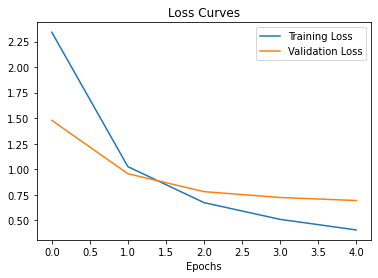

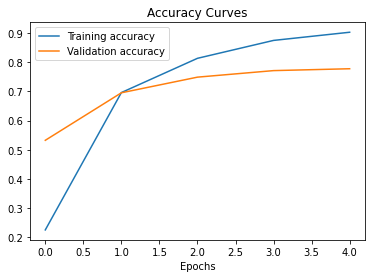

In [30]:
plot_loss_curves(resenet_history)

In [31]:
# Much better loss curves

## Creating ResNet TensorFlow HUB Feature Extraction mdoel

In [37]:
effnet_model = create_model(model_url=efficientnet_url, num_classes=train_data.num_classes)

effnet_model.compile(loss="categorical_crossentropy",
                     optimizer=Adam(),
                     metrics=["accuracy"])

effnet_history = effnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name="EfficientNetB0")])

Saving Tensorboard log files to:  tensorflow_hub/EfficientNetB0/20221124-$H5301
Epoch 1/5
24/24 [==============================] - 27s 701ms/step - loss: 1.8337 - accuracy: 0.4360 - val_loss: 1.3028 - val_accuracy: 0.7220
Epoch 2/5
24/24 [==============================] - 15s 640ms/step - loss: 1.0613 - accuracy: 0.7747 - val_loss: 0.8734 - val_accuracy: 0.8200
Epoch 3/5
24/24 [==============================] - 15s 638ms/step - loss: 0.7604 - accuracy: 0.8387 - val_loss: 0.6968 - val_accuracy: 0.8432
Epoch 4/5
24/24 [==============================] - 15s 634ms/step - loss: 0.6116 - accuracy: 0.8640 - val_loss: 0.6102 - val_accuracy: 0.8532
Epoch 5/5
24/24 [==============================] - 18s 773ms/step - loss: 0.5166 - accuracy: 0.8853 - val_loss: 0.5569 - val_accuracy: 0.8624


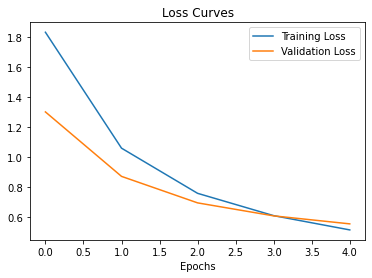

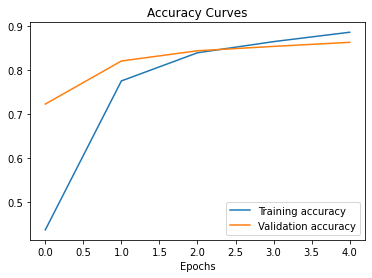

In [38]:
plot_loss_curves(effnet_history)

In [39]:
# Excellent Efficient Net B) is working quitely high and much better than Resnet-50

In [40]:
effnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [42]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [43]:
# Comparing total parameters it can be observed that efficient net is performing much well in comparison with resent

In [49]:
# CHecking the no. layers in efficienct net
len(effnet_model.layers[0].weights)

309

In [50]:
# Comparing our model Using TensorBoard

In [51]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs, ResNet50V2" \
  --description "Comparing two different TF hub fetature extraction model architecture with our food 101 vision" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=vWh8ATQy6BKyTtgptHJYOKO0Em9qSi&prompt=consent&access_type=off

#### Our tensorboard experiments are uploaded publically here: https://tensorboard.dev/experiment/UYDC1RE4TRWZOm83TYf1TQ/

In [52]:
# Checking experiments running on Tensor Board
!tensorboard dev list

https://tensorboard.dev/experiment/UYDC1RE4TRWZOm83TYf1TQ/
	Name                 EfficientNetB0 vs, ResNet50V2
	Description          Comparing two different TF hub fetature extraction model architecture with our food 101 vision
	Id                   UYDC1RE4TRWZOm83TYf1TQ
	Created              2022-11-24 18:22:02 (5 minutes ago)
	Updated              2022-11-24 18:22:07 (5 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5794895
Total: 1 experiment(s)


In [53]:
# delete an experiment
# !tensorboard dev delete --experiment_id UYDC1RE4TRWZOm83TYf1TQ